<a href="https://colab.research.google.com/github/vanyagoncharov/CourseMLResourse/blob/main/dz_20_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
# Импорт используемых библиотек
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

## Функции

In [2]:
# Функция для расчета метрик и построения кривой ROC
def calculate_metrics_and_plot_roc(model, X_train, y_train, X_test, y_test):
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на обучающей и тестовой выборке
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Расчет метрик precision и recall
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)

    print(f"Training Precision: {train_precision:.2f}")
    print(f"Training Recall: {train_recall:.2f}")
    print(f"Test Precision: {test_precision:.2f}")
    print(f"Test Recall: {test_recall:.2f}")

    metrics =  {'params': ['Training_Precision', 'Test_Precision','Training_Recall', 'Test_Recall'],
                'values': [train_precision, test_precision, train_recall, test_recall]}

    # Расчет ROC-AUC на тестовой выборке
    try:
      pred_test = model.predict_proba(X_test)
      pred_train = model.predict_proba(X_train)
      roc_auc_test = roc_auc_score(y_test, pred_test[:, 1])
      roc_auc_train = roc_auc_score(y_train, pred_train[:, 1])
      print(f"ROC-AUC_test = : {roc_auc_test:.2f} и ROC-AUC_train = : {roc_auc_train:.2f}")

      # Построение кривой ROC
      fpr_test, tpr_test, _ = roc_curve(y_test, pred_test[:, 1])
      fpr_train, tpr_train, _ = roc_curve(y_train, pred_train[:, 1])
      plt.figure()
      plt.plot(fpr_test, tpr_test, color='blue', lw=2, label = 'ROC Curve test')
      plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label = 'ROC Curve train')
      plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.legend()
      plt.title(f'ROC Curve ({type(model).__name__})')
      plt.show()
    except Exception as e:
      print(e)
    return metrics




## Загрузка данных

In [3]:
# Загрузка данных
data = sns.load_dataset('titanic')

# Разделение на целевую переменную и показатели
X = data.drop(columns='survived')
y = data["survived"]

## Провести разведочный анализ данных, ответив на следующие вопросы:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


### Сколько строк в датафрейме, сколько столбцов

In [5]:
# Вывод информации о датасете
print(f'Информация о датасете: \n {X.shape[0]}: строк\n {X.shape[1]}: столбцов\n '
      f'{np.round(data.memory_usage(index=True).sum() / 1024, 4)} КБ: занимаемый объем памяти')

Информация о датасете: 
 891: строк
 14: столбцов
 80.6523 КБ: занимаемый объем памяти


### Для каждой категориальной переменной рассчитать моду и сколько раз мода встречается в данных

In [6]:
# Выбираем только интервальные переменные (столбцы с числовыми значениями)
num_cols = ['age', 'fare']
num_data = data[num_cols]

# Рассчитываем основные характеристики для каждой переменной
stats_df = num_data.describe().T

# Выводим результат
print(stats_df)

      count       mean        std   min      25%      50%   75%       max
age   714.0  29.699118  14.526497  0.42  20.1250  28.0000  38.0   80.0000
fare  891.0  32.204208  49.693429  0.00   7.9104  14.4542  31.0  512.3292


### Для каждой категориальной переменной рассчитать моду и сколько раз мода встречается в данных

In [7]:
# Создаем DataFrame, содержащий только категориальные переменные
cat_cols = ['survived', 'pclass', 'sex', 'sibsp', 'parch', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
cat_data = data[cat_cols]

# Рассчитываем моду и количество ее встреч для каждой переменной
mode_df = pd.DataFrame({'mode': cat_data.mode().iloc[0], 'count': cat_data.apply(lambda x: x.value_counts().max())})

# Выводим результат
print(mode_df)


                    mode  count
survived               0    549
pclass                 3    491
sex                 male    577
sibsp                  0    608
parch                  0    678
embarked               S    644
class              Third    491
who                  man    537
adult_male          True    537
deck                   C     59
embark_town  Southampton    644
alive                 no    549
alone               True    537


## Подготовка датасета к построению моделей ML

### Провести анализ и обработку пропусков (либо заменить, либо удалить)

In [8]:
# Анализ пропусков
X.isnull().sum()

pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [9]:
# Заполнение пропущенных значений в столбце 'age' медианным значением
X['age'].fillna(X['age'].median(), inplace=True)

# Заполнение пропущенных значений в столбце 'embarked' наиболее часто встречающимся значением
embarked_mode = X['embarked'].mode()[0]
X['embarked'].fillna(embarked_mode, inplace=True)

# Сначала получим текущие категории
current_categories = X['deck'].cat.categories.tolist()
# Добавим новую категорию 'Unknown' в список категорий, если она еще не существует
if 'Unknown' not in current_categories:
  new_categories = current_categories + ['Unknown']
else:
  new_categories = current_categories
# Установим обновленные категории в переменную 'deck'
X['deck'] = X['deck'].cat.set_categories(new_categories)

# Заполнение пропущенных значений в столбце 'deck' значением Unknown
X.loc[X['deck'].isnull(), 'deck'] = 'Unknown'

# Заполнение пропущенных значений в столбце 'embark_town' значением Unknown
X["embark_town"].fillna("Unknown", inplace=True)

In [10]:
# Анализ пропусков
X.isnull().sum()

pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
deck           0
embark_town    0
alive          0
alone          0
dtype: int64

### Провести анализ и обработку выбросов (либо заменить, либо удалить)

In [11]:
# заменяем значения True и False на 1 и 0
X['alone'] = X['alone'].replace({True: 1, False: 0})
# заменяем значения yes и no на 1 и 0
X['alive'] = X['alive'].replace({'yes': 1, 'no': 0})

In [12]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [13]:
# sibsp: количество братьев/сестер и/или супругов на борту.
# parch: количество родителей/детей на борту
# alone: указывает, был ли пассажир на борту один или нет
# embarked: порт, в котором пассажир сел на борт Титаника.
# alive: жив или мертв
# who: пол
X = X.drop(['sibsp', 'parch', 'alone', 'embarked', 'alive', 'who'], axis=1)

In [14]:
X

,pclass,sex,age,fare,class,adult_male,deck,embark_town
0,3,male,22.0,7.2500,Third,True,Unknown,Southampton
1,1,female,38.0,71.2833,First,False,C,Cherbourg
2,3,female,26.0,7.9250,Third,False,Unknown,Southampton
3,1,female,35.0,53.1000,First,False,C,Southampton
4,3,male,35.0,8.0500,Third,True,Unknown,Southampton
...,...,...,...,...,...,...,...,...
886,2,male,27.0,13.0000,Second,True,Unknown,Southampton
887,1,female,19.0,30.0000,First,False,B,Southampton
888,3,female,28.0,23.4500,Third,False,Unknown,Southampton
889,1,male,26.0,30.0000,First,True,C,Cherbourg


### Провести анализ и обработку категориальных переменных (сколько таких переменных, закодируйте категориальные переменные одним из методов (one hot encoding, mean target, frequence encoding)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   pclass       891 non-null    int64   
 1   sex          891 non-null    object  
 2   age          891 non-null    float64 
 3   fare         891 non-null    float64 
 4   class        891 non-null    category
 5   adult_male   891 non-null    bool    
 6   deck         891 non-null    category
 7   embark_town  891 non-null    object  
dtypes: bool(1), category(2), float64(2), int64(1), object(2)
memory usage: 38.0+ KB


In [16]:
# Проверка наличия категориальных переменных
cat_vars = [col for col in X.columns if data[col].dtype == 'object' or data[col].dtype == 'category']
print(f"Категориальные переменные: {cat_vars}")

# Закодируем категориальные переменные методом one hot encoding
X = pd.get_dummies(X, columns=cat_vars)
X.head()

Категориальные переменные: ['sex', 'class', 'deck', 'embark_town']


,pclass,age,fare,adult_male,sex_female,sex_male,class_First,class_Second,class_Third,deck_A,...,deck_C,deck_D,deck_E,deck_F,deck_G,deck_Unknown,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_Unknown
0,3,22.0,7.2500,True,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
1,1,38.0,71.2833,False,1,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,3,26.0,7.9250,False,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
3,1,35.0,53.1000,False,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,3,35.0,8.0500,True,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0


## Модели

### KNN

In [17]:
# Перекодировка
y_bin = y

In [18]:
np.random.seed(123)

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, train_size=0.8, stratify=y_bin)

# # Отмасштабируйте признаки
# ss = StandardScaler()

# X_train = ss.fit_transform(X_train)

# X_test = ss.transform(X_test)


In [19]:
# Построение модели k-Nearest Neighbors (kNN)
knn_model = KNeighborsClassifier()

In [20]:
# Задаем сетку параметров для значения "n_neighbors", которое мы хотим исследовать
param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 14]}  # Пример значений, можно изменить диапазон по необходимости

# Создаем объект GridSearchCV с моделью KNN и сеткой параметров
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='roc_auc')  # Параметр cv определяет количество фолдов в кросс-валидации

# Обучаем модель на данных с помощью кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее найденное значение параметра "n_neighbors" в результате кросс-валидации
best_n_neighbors = grid_search.best_params_['n_neighbors']
print('best_n_neighbors =', best_n_neighbors)


best_n_neighbors = 5


In [21]:
best_knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)

In [22]:
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Training Precision: 0.81
Training Recall: 0.71
Test Precision: 0.65
Test Recall: 0.57
ROC-AUC_test = : 0.76 и ROC-AUC_train = : 0.90


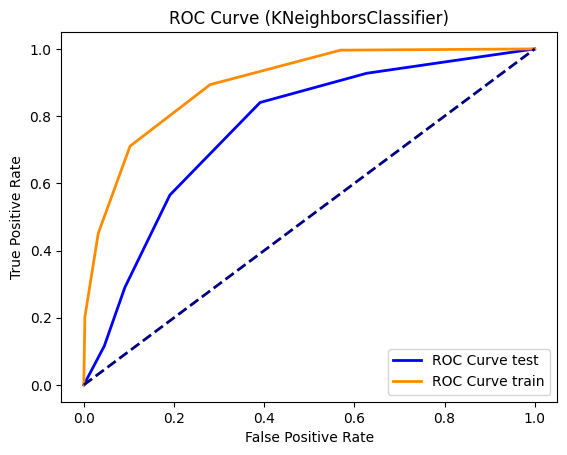

In [23]:
metrics_knn = calculate_metrics_and_plot_roc(best_knn_model, X_train, y_train, X_test, y_test)

### LogisticRegression

In [ ]:
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 20, 30, 50, 100],
              'penalty': ['l2', 'l1'],
              # 'solver': ['liblinear', 'saga']
              }

# Создаем модель логистической регрессии
logreg_model = LogisticRegression(solver='saga', max_iter=100000)

# Создаем объект RandomizedSearchCV с моделью логистической регрессии и сеткой параметров
random_search = RandomizedSearchCV(logreg_model,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=5, scoring='roc_auc')

# Обучаем модель на данных с использованием кросс-валидации
random_search.fit(X_train, y_train)

# Получаем лучшее значение параметров, найденных в процессе кросс-валидации
print('Лучшие значения параметров:', random_search.best_params_)


In [ ]:
# Построение модели логистической регрессии
logreg_model = LogisticRegression(solver='saga',  max_iter=1000, **random_search.best_params_)
# plot_decision_boundary(logreg_model, X_train, y_train)

In [ ]:
# Обучение модели
logreg_model.fit(X_train, y_train)

In [ ]:
metrics_logreg  = calculate_metrics_and_plot_roc(logreg_model, X_train, y_train, X_test, y_test)

### SVC

#### SVM линейный

In [ ]:
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              }

# Создаем модель логистической регрессии
svm_model = SVC(kernel='linear', C=0.0)

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель логистической регрессии с лучшим значением C
best_svm_model = SVC(kernel='linear', **grid_search.best_params_)

In [ ]:
metrics_svm_linear  = calculate_metrics_and_plot_roc(best_svm_model, X_train, y_train, X_test, y_test)

#### SVM не линейный

In [ ]:
# Определяем сетку параметров для C, которые мы хотим проверить
param_grid = {'C': [0.01, 0.1, 1],
              'kernel':['linear', 'poly', 'rbf', 'sigmoid',]
              }

# Создаем модель логистической регрессии
svm_model = SVC(kernel='linear')

# Создаем объект GridSearchCV с моделью логистической регрессии и сеткой параметров
grid_search = GridSearchCV(svm_model, param_grid, cv=5)  # cv указывает количество блоков для кросс-валидации

# Обучаем модель на данных с использованием кросс-валидации
grid_search.fit(X_train, y_train)

# Получаем лучшее значение параметра C, найденное в процессе кросс-валидации
# best_params = grid_search.best_params_[param_grid]
print('Лучшее значение параметра:', grid_search.best_params_)


# Создаем модель логистической регрессии с лучшим значением C
best_svm_model = SVC(**grid_search.best_params_)

In [ ]:
metrics_svm_not_linear  = calculate_metrics_and_plot_roc(best_svm_model, X_train, y_train, X_test, y_test)

## Вывод

In [ ]:
metrics_svm_not_linear['metrics'] = ['metrics_svm_not_linear' for i in range(4)]
metrics_svm_linear['metrics'] = ['metrics_svm_linear' for i in range(4)]
metrics_logreg['metrics'] = ['metrics_logreg' for i in range(4)]
metrics_knn['metrics'] = ['metrics_knn' for i in range(4)]

In [ ]:
df_stat = pd.concat([pd.DataFrame(metrics_svm_not_linear),
                    pd.DataFrame(metrics_svm_linear),
                    pd.DataFrame(metrics_logreg),
                    pd.DataFrame(metrics_knn)])

In [ ]:
df_stat = df_stat.pivot_table(columns = 'params',
                            index='metrics',
                            values='values').reset_index()[['metrics','Test_Precision',	'Training_Precision',
                                                            'Test_Recall',	'Training_Recall']]
df_stat['dif_Precision'] = round((df_stat['Test_Precision'] - df_stat['Training_Precision'])/df_stat['Training_Precision'],2)

df_stat['dif_Recall'] = round((df_stat['Test_Recall'] - df_stat['Training_Recall'])/df_stat['Training_Recall'],2)
df_stat

Вывод:

1.  Модель "metrics_knn" имеет более высокую точность на тренировочных данных (0.830357) по сравнению с тестовыми данными (0.704225), что указывает на переобучение модели.
2.   Модель "metrics_logreg" имеет схожие значения точности как на тренировочных данных (0.748120), так и на тестовых данных (0.742424). Однако, она имеет небольшое снижение полноты на тренировочных данных по сравнению с тестовыми данными.
3. Модель "metrics_svm_linear" также имеет схожие значения точности как на тренировочных данных (0.743083), так и на тестовых данных (0.741935). Однако, она имеет снижение полноты на тренировочных данных по сравнению с тестовыми данными.
4. Модель "metrics_svm_not_linear" имеет высокую точность на тренировочных данных (0.899038), но более низкую точность на тестовых данных (0.786885). Она также имеет небольшое повышение полноты на тренировочных данных по сравнению с тестовыми данными.


**Исходя из представленных метрик, модель "metrics_logreg" кажется более оптимальной. Она имеет сравнительно хорошую точность как на тренировочных, так и на тестовых данных, и наименьшее снижение полноты.**

Чтобы улучшить алгоритмы, можно рассмотреть следующие действия:


*   Регуляризация: Некоторые модели могут быть подвержены переобучению. Применение регуляризации может помочь улучшить обобщающую способность модели.
*   Отбор и создание новых признаков: Иногда добавление новых значимых признаков или отбор наиболее информативных признаков может улучшить производительность модели.

